In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import stats
import scipy.special
import tqdm
import matplotlib.pyplot as plt

import hetmech.degree_weight
import hetmech.matrix
import hetmech.degree_group
from hetmech.hetmat import HetMat

%matplotlib inline

In [3]:
def gamma_pdf(x, a, b):
    if all((x > 0, a > 0, b > 0)):
        return (b ** a) * (x ** (a - 1)) * (np.exp(-b * x)) / scipy.special.gamma(a)
    return np.nan

In [4]:
def gamma_cdf(x, a, b):
    if all((x > 0, a > 0, b > 0)):
        return scipy.special.gammainc(a, b * x)
    return np.nan

In [5]:
hetmat = HetMat('../data/hetionet-v1.0.hetmat/')

In [6]:
metapath = 'DtCpD'

In [7]:
# Compute actual values
_, _, dwpc_mat = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=1)
dwpc_df = pd.DataFrame(hetmech.degree_group.dwpc_to_degrees(hetmat, metapath))

# Compute Degree-grouped permutations
source_degree_to_ind, target_degree_to_ind = hetmech.degree_group.metapath_to_degree_dicts(hetmat, metapath)

for name, permat in tqdm.tqdm((hetmat.permutations.items())):  
    path = permat.directory.joinpath('degree-grouped-path-counts', 'dwpc-0.5', f'{metapath}.tsv')
    degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
        permat, metapath, dwpc_mean=(dwpc_mat).mean(), damping=0.5)
    path.parent.mkdir(parents=True, exist_ok=True)
    degree_grouped_df.to_csv(path, sep='\t')

# Fit inverse gamma distributions
dgp_df = hetmech.degree_group.summarize_degree_grouped_permutations(hetmat, metapath, 0.5)
dgp_df['mean-nz'] = dgp_df['sum'] / dgp_df['nnz']
dgp_df['var-nz'] = (dgp_df['sum_of_squares'] - (dgp_df['sum']) ** 2 / dgp_df['nnz']) / (dgp_df['nnz'] - 1)
dgp_df['beta'] = dgp_df['mean-nz'] / dgp_df['var-nz']
dgp_df['alpha'] = dgp_df['mean-nz'] * dgp_df['beta']
dgp_df = dgp_df.reset_index()

# Calculate P-values
dwpc_df = dwpc_df.merge(dgp_df, on=['source_degree', 'target_degree'])
dwpc_df['z-dwpc'] = (dwpc_df['dwpc'] - dwpc_df['mean']) / dwpc_df['sd']
dwpc_df['normal-p-value'] = dwpc_df.apply(lambda row: 1 - stats.norm.cdf(row['z-dwpc']), axis=1)
dwpc_df['p-value'] = dwpc_df.apply(lambda row: 1 - gamma_cdf(row['dwpc'], row['alpha'], row['beta']), axis=1)
dwpc_df['hurdle-p'] = (dwpc_df['nnz'] / dwpc_df['n']) * dwpc_df['p-value']

100%|██████████| 145/145 [00:08<00:00, 17.77it/s]


In [8]:
dwpc_df.head()

,dwpc,path-count,source_degree,source_id,source_name,target_degree,target_id,target_name,n,nnz,...,mean,sd,mean-nz,var-nz,beta,alpha,z-dwpc,normal-p-value,p-value,hurdle-p
0,5.561817,5.561817,9,DOID:13189,gout,1,DOID:0050156,idiopathic pulmonary fibrosis,7250,45,...,0.034337,0.438000,5.532102,0.500925,11.043766,61.095243,12.619806,0.000000e+00,0.466308,0.002894
1,5.561817,5.561817,9,DOID:3083,chronic obstructive pulmonary disease,1,DOID:0050156,idiopathic pulmonary fibrosis,7250,45,...,0.034337,0.438000,5.532102,0.500925,11.043766,61.095243,12.619806,0.000000e+00,0.466308,0.002894
2,5.461485,5.461485,11,DOID:2377,multiple sclerosis,1,DOID:0050156,idiopathic pulmonary fibrosis,7250,88,...,0.065166,0.592069,5.368831,0.406331,13.212939,70.938031,9.114343,0.000000e+00,0.426983,0.005183
3,4.694586,4.694586,51,DOID:2531,hematologic cancer,1,DOID:0050156,idiopathic pulmonary fibrosis,1450,78,...,0.264692,1.120761,4.920557,0.430633,11.426347,56.223990,3.952577,3.865697e-05,0.619863,0.033344
4,4.855016,4.855016,37,DOID:2841,asthma,1,DOID:0050156,idiopathic pulmonary fibrosis,1450,53,...,0.175277,0.906718,4.795306,0.328667,14.590147,69.964220,5.161187,1.226947e-07,0.442929,0.016190


In [12]:
dwpc_df[dwpc_df['p-value'] < dwpc_df['normal-p-value']]

,dwpc,path-count,source_degree,source_id,source_name,target_degree,target_id,target_name,n,nnz,...,mean,sd,mean-nz,var-nz,beta,alpha,z-dwpc,normal-p-value,p-value,hurdle-p
16,5.677735,5.677735,68,DOID:10763,hypertension,10,DOID:3393,coronary artery disease,435,212,...,1.803850,1.918364,3.701295,0.513247,7.211533,26.692016,2.019369,0.021724,0.007299,0.003557
17,5.956472,5.956472,68,DOID:10763,hypertension,10,DOID:784,chronic kidney failure,435,212,...,1.803850,1.918364,3.701295,0.513247,7.211533,26.692016,2.164668,0.015207,0.003153,0.001537
36,4.816406,4.816406,68,DOID:10763,hypertension,14,DOID:1094,attention deficit hyperactivity disorder,290,169,...,2.142539,1.910539,3.676546,0.605727,6.069639,22.315307,1.399535,0.080826,0.080042,0.046645
38,6.465716,6.465716,21,DOID:10283,prostate cancer,14,DOID:1612,breast cancer,870,240,...,1.063399,1.759524,3.854822,0.451270,8.542164,32.928524,3.070329,0.001069,0.000479,0.000132
42,5.037299,5.037299,68,DOID:10763,hypertension,9,DOID:11119,Gilles de la Tourette syndrome,290,125,...,1.643440,1.938082,3.812782,0.416350,9.157643,34.916096,1.751143,0.039961,0.037467,0.016150
97,5.937941,5.937941,25,DOID:1826,epilepsy syndrome,22,DOID:2377,multiple sclerosis,145,64,...,1.411926,1.640340,3.198895,0.343144,9.322310,29.821093,2.759193,0.002897,0.000066,0.000029
124,6.107161,6.107161,25,DOID:1826,epilepsy syndrome,20,DOID:3312,bipolar disorder,145,80,...,2.019130,1.902977,3.659673,0.521039,7.023794,25.704791,2.148230,0.015848,0.001861,0.001026
134,5.322678,5.322678,25,DOID:1826,epilepsy syndrome,30,DOID:5419,schizophrenia,145,78,...,2.039876,1.977761,3.792077,0.584308,6.489860,24.610051,1.659858,0.048472,0.032304,0.017377
136,5.537588,5.537588,15,DOID:4481,allergic rhinitis,30,DOID:5419,schizophrenia,435,190,...,1.677649,1.968187,3.840934,0.542303,7.082636,27.203935,1.961165,0.024930,0.018137,0.007922


In [19]:
dwpc_df[dwpc_df['hurdle-p'] < dwpc_df['normal-p-value']]

,dwpc,path-count,source_degree,source_id,source_name,target_degree,target_id,target_name,n,nnz,...,mean,sd,mean-nz,var-nz,beta,alpha,z-dwpc,normal-p-value,p-value,hurdle-p
16,5.677735,5.677735,68,DOID:10763,hypertension,10,DOID:3393,coronary artery disease,435,212,...,1.803850,1.918364,3.701295,0.513247,7.211533,26.692016,2.019369,0.021724,0.007299,0.003557
17,5.956472,5.956472,68,DOID:10763,hypertension,10,DOID:784,chronic kidney failure,435,212,...,1.803850,1.918364,3.701295,0.513247,7.211533,26.692016,2.164668,0.015207,0.003153,0.001537
20,5.738345,5.738345,25,DOID:1826,epilepsy syndrome,10,DOID:0050425,restless legs syndrome,435,101,...,0.899663,1.665144,3.874788,0.390276,9.928321,38.470140,2.905864,0.001831,0.003932,0.000913
36,4.816406,4.816406,68,DOID:10763,hypertension,14,DOID:1094,attention deficit hyperactivity disorder,290,169,...,2.142539,1.910539,3.676546,0.605727,6.069639,22.315307,1.399535,0.080826,0.080042,0.046645
38,6.465716,6.465716,21,DOID:10283,prostate cancer,14,DOID:1612,breast cancer,870,240,...,1.063399,1.759524,3.854822,0.451270,8.542164,32.928524,3.070329,0.001069,0.000479,0.000132
42,5.037299,5.037299,68,DOID:10763,hypertension,9,DOID:11119,Gilles de la Tourette syndrome,290,125,...,1.643440,1.938082,3.812782,0.416350,9.157643,34.916096,1.751143,0.039961,0.037467,0.016150
77,4.262042,4.262042,25,DOID:1826,epilepsy syndrome,28,DOID:14330,Parkinson's disease,145,77,...,1.975738,1.914897,3.720546,0.370625,10.038584,37.349016,1.193957,0.116247,0.183107,0.097236
82,4.731344,4.731344,22,DOID:9352,type 2 diabetes mellitus,28,DOID:14330,Parkinson's disease,145,62,...,1.586931,1.898089,3.711372,0.490991,7.558943,28.054050,1.656620,0.048798,0.080467,0.034407
86,5.918650,5.918650,15,DOID:11476,osteoporosis,14,DOID:1612,breast cancer,870,196,...,0.895075,1.689692,3.973038,0.431741,9.202368,36.561362,2.973071,0.001474,0.004212,0.000949
97,5.937941,5.937941,25,DOID:1826,epilepsy syndrome,22,DOID:2377,multiple sclerosis,145,64,...,1.411926,1.640340,3.198895,0.343144,9.322310,29.821093,2.759193,0.002897,0.000066,0.000029


In [13]:
dwpc_df.sort_values(by='p-value')

,dwpc,path-count,source_degree,source_id,source_name,target_degree,target_id,target_name,n,nnz,...,mean,sd,mean-nz,var-nz,beta,alpha,z-dwpc,normal-p-value,p-value,hurdle-p
97,5.937941,5.937941,25,DOID:1826,epilepsy syndrome,22,DOID:2377,multiple sclerosis,145,64,...,1.411926,1.640340,3.198895,0.343144,9.322310,29.821093,2.759193,2.897215e-03,0.000066,0.000029
38,6.465716,6.465716,21,DOID:10283,prostate cancer,14,DOID:1612,breast cancer,870,240,...,1.063399,1.759524,3.854822,0.451270,8.542164,32.928524,3.070329,1.069117e-03,0.000479,0.000132
133,7.047010,7.047010,2,DOID:9206,Barrett's esophagus,3,DOID:5041,esophageal cancer,2175,22,...,0.054793,0.544239,5.417050,0.232522,23.296889,126.200404,12.847695,0.000000e+00,0.000906,0.000009
124,6.107161,6.107161,25,DOID:1826,epilepsy syndrome,20,DOID:3312,bipolar disorder,145,80,...,2.019130,1.902977,3.659673,0.521039,7.023794,25.704791,2.148230,1.584776e-02,0.001861,0.001026
17,5.956472,5.956472,68,DOID:10763,hypertension,10,DOID:784,chronic kidney failure,435,212,...,1.803850,1.918364,3.701295,0.513247,7.211533,26.692016,2.164668,1.520654e-02,0.003153,0.001537
125,5.714455,5.714455,7,DOID:6364,migraine,20,DOID:3312,bipolar disorder,725,128,...,0.712762,1.558381,4.037126,0.318090,12.691793,51.238372,3.209546,6.647243e-04,0.003625,0.000640
20,5.738345,5.738345,25,DOID:1826,epilepsy syndrome,10,DOID:0050425,restless legs syndrome,435,101,...,0.899663,1.665144,3.874788,0.390276,9.928321,38.470140,2.905864,1.831203e-03,0.003932,0.000913
166,6.263704,6.263704,15,DOID:11476,osteoporosis,10,DOID:784,chronic kidney failure,1305,197,...,0.643753,1.549520,4.264458,0.454966,9.373140,39.971360,3.626897,1.434236e-04,0.004050,0.000611
86,5.918650,5.918650,15,DOID:11476,osteoporosis,14,DOID:1612,breast cancer,870,196,...,0.895075,1.689692,3.973038,0.431741,9.202368,36.561362,2.973071,1.474183e-03,0.004212,0.000949
16,5.677735,5.677735,68,DOID:10763,hypertension,10,DOID:3393,coronary artery disease,435,212,...,1.803850,1.918364,3.701295,0.513247,7.211533,26.692016,2.019369,2.172443e-02,0.007299,0.003557


In [20]:
dwpc_df.mean()

dwpc                 4.797622
path-count           4.797622
source_degree       17.728205
target_degree       12.107692
n                 1724.384615
nnz                118.841026
sum                497.483644
sum_of_squares    2163.237296
n_perms            145.000000
mean                 0.781493
sd                   1.395727
mean-nz              4.349398
var-nz               0.434421
beta                10.816390
alpha               48.873356
z-dwpc               4.086752
normal-p-value       0.040405
p-value              0.326146
hurdle-p             0.072105
dtype: float64

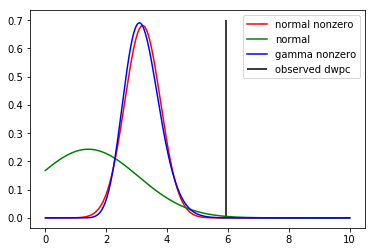

In [15]:
row = dwpc_df.iloc[97, :]

x = np.linspace(0, 10, 1000)
norm_nz = stats.norm.pdf(x, loc=row['mean-nz'], scale=(row['var-nz'])**0.5)
gam = [gamma_pdf(i, row['alpha'], row['beta']) for i in x]
norm = stats.norm.pdf(x, loc=row['mean'], scale=row['sd'])


plt.plot(x, norm_nz, color='r', label='normal nonzero')
plt.plot(x, norm, color='g', label='normal')
plt.vlines(row['dwpc'], 0, 0.7, label='observed dwpc')
plt.plot(x, gam, color='b', label='gamma nonzero')
plt.legend();

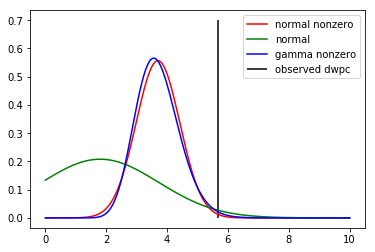

In [55]:
row = dwpc_df.iloc[16, :]

x = np.linspace(0, 10, 1000)
norm_nz = stats.norm.pdf(x, loc=row['mean-nz'], scale=(row['var-nz'])**0.5)
gam = [gamma_pdf(i, row['alpha'], row['beta']) for i in x]
norm = stats.norm.pdf(x, loc=row['mean'], scale=row['sd'])


plt.plot(x, norm_nz, color='r', label='normal nonzero')
plt.plot(x, norm, color='g', label='normal')
plt.vlines(row['dwpc'], 0, 0.7, label='observed dwpc')
plt.plot(x, gam, color='b', label='gamma nonzero')
plt.legend();

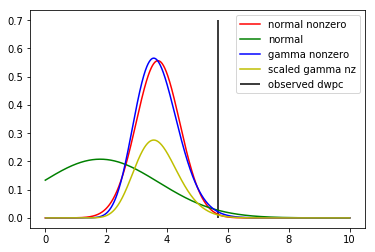

In [22]:
row = dwpc_df.iloc[16, :]

scaling = row['nnz'] / row['n']

x = np.linspace(0, 10, 1000)
norm_nz = stats.norm.pdf(x, loc=row['mean-nz'], scale=(row['var-nz'])**0.5)
gam = [gamma_pdf(i, row['alpha'], row['beta']) for i in x]
norm = stats.norm.pdf(x, loc=row['mean'], scale=row['sd'])

scaled_gamma = [i * scaling for i in gam]

plt.plot(x, norm_nz, color='r', label='normal nonzero')
plt.plot(x, norm, color='g', label='normal')
plt.vlines(row['dwpc'], 0, 0.7, label='observed dwpc')
plt.plot(x, gam, color='b', label='gamma nonzero')
plt.plot(x, scaled_gamma, color='y', label='scaled gamma nz')

plt.legend();

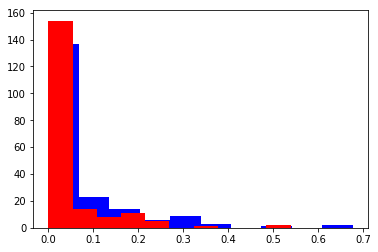

In [58]:
plt.hist(dwpc_df['hurdle-p'], color='b')
plt.hist(dwpc_df['normal-p-value'], color='r');